<a href="https://colab.research.google.com/github/babakbadakhshan/urban-network-analysis/blob/main/15mincity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandana

In [ ]:
pip install osmnx

In [3]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# Select city and crs
cityname = 'شهر تهران, Iran'
crs = 3857

In [7]:
# Get graph by geocoding
graph = ox.graph_from_place(cityname, network_type="walk")

# Project graph
graph = ox.projection.project_graph(graph, to_crs=crs)

In [8]:
# Select points of interest based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from place
pois = ox.geometries.geometries_from_place(cityname, tags=tags)

# Project pois
pois = pois.to_crs(epsg=crs)

<ipython-input-8-e968dad67538>:25: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries.geometries_from_place(cityname, tags=tags)


In [9]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed
graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [10]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'],
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the pois' geometries
centroids = pois.centroid

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the pois' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x,
    y_col=centroids.y
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
25920665,93,137,140,184,215,379,508,517,518,579
1921578869,108,152,155,169,224,394,502,503,519,590
1921578857,112,156,159,177,234,398,489,510,511,560
4421793434,86,130,133,191,208,372,515,524,525,586
25920706,274,331,374,417,490,533,533,541,541,541


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

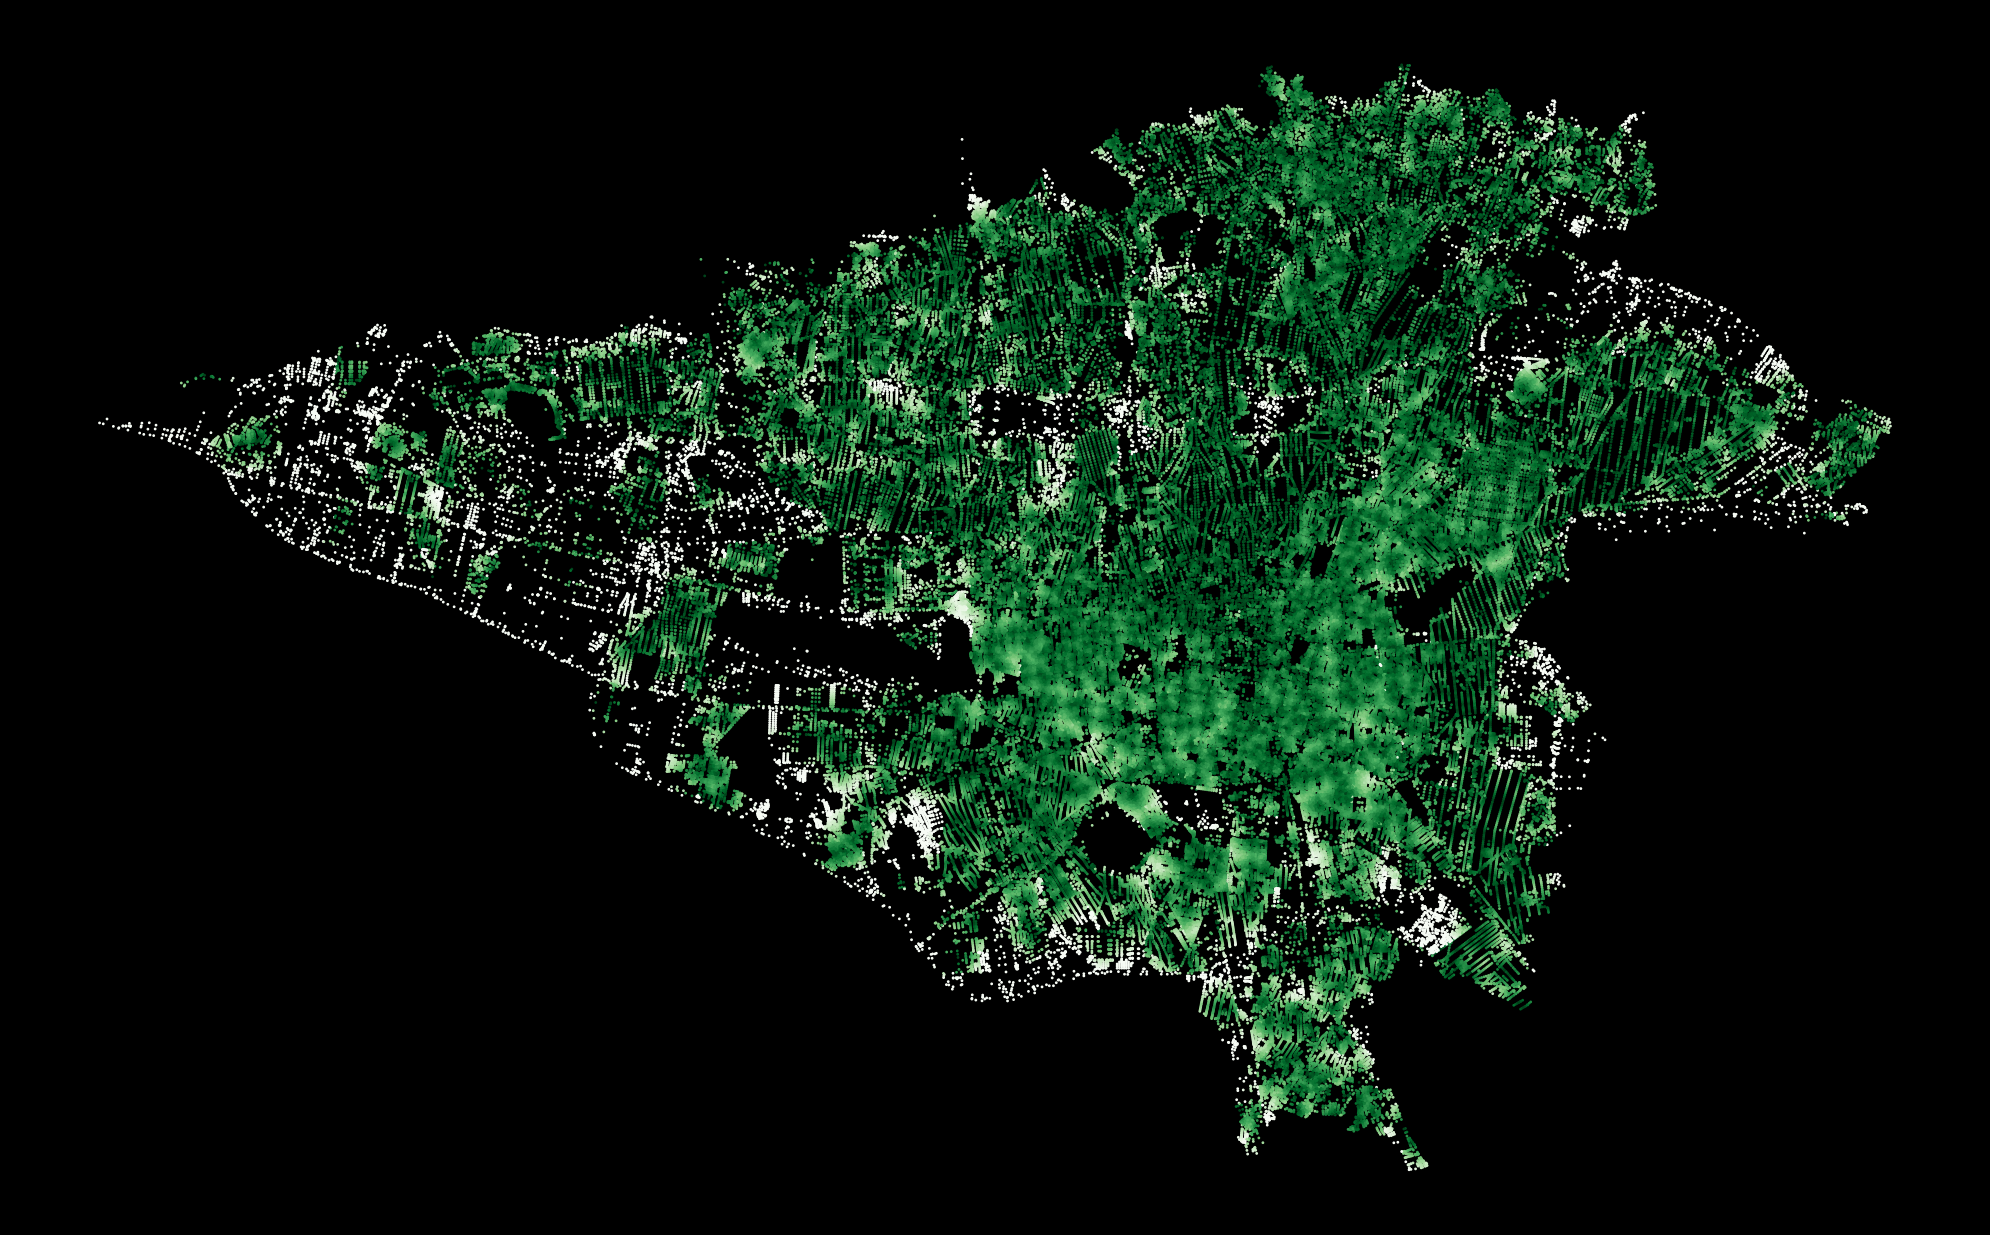

In [13]:
# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest everyday errands
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'],
    c=distances[1],
    s=1,
    cmap='Greens_r',
)

# Remove empty space
plt.tight_layout()
